In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import os

imagedir = 'images'
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)
#For numeric stability
EPSILON = 1e-10

df = pd.read_csv('ListingsAndSales.csv')
#not sold flag

df['NotSoldFlag'] = 0
df.loc[df['SalesDate'].isnull() == True, 'NotSoldFlag'] = 1
print('percent not yet sold:', df['NotSoldFlag'].mean())

df.ListingDate, df.SalesDate = [pd.to_datetime(col) for col in [df.ListingDate, df.SalesDate]]
df.SalesDate = df.SalesDate.fillna(df.SalesDate.max())

#Get day of dataset for each sample
df['ListingDay'] = (df.ListingDate - df.ListingDate.min()).dt.days
df = df.sort_values('ListingDay')

#calculate days it took to sell the listing if it's sold
df['DaysSold'] = (df.SalesDate - df.ListingDate).dt.days.astype(float) + 1

#loop through the variables and replace missing values with avg and create dummy variables
col_dates = ['ListingDate', 'SalesDate']
for col in df.columns:
    if not col in col_dates:
        if df[col].isnull().sum(axis=0) > 0:
            df[col + "_null_flag"] = (df[col].isnull())
            col_avg = df.loc[df[col].isnull() == False, col].mean()
            df[col] = df[col].fillna(col_avg)

#Columns to use as regressors
X = df.drop(['DaysSold', 'ListingDate', 'SalesDate', 'NotSoldFlag'], axis=1)

#Column to use as target
Y = df[['DaysSold']].as_matrix().astype(np.float32)

scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(X), columns=X.columns).as_matrix().astype(np.float32)
sold = df['NotSoldFlag'].as_matrix().astype(np.float32)

class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes

        self.sold = tf.placeholder(tf.float32, shape=(None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))

        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(
                tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)

        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))

        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) *
                               (1 - self.sold) + self.sold)
        loss_numerator = tf.reduce_sum(
            tf.square(self.y - self.output) * self.loss_indicator)
        loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
        self.loss = loss_numerator / loss_denominator

        self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        
        self.sess = tf.Session()
        
        self.trn_losses = []
        self.val_losses = []
        self.r2_scores = []

    def train_one_epoch(self, trn_samples, bs, X_train, Y_train, sold_train):
        #Train an epoch
        trn_loss = []
        #Randomly shuffle data and prepare for training
        order = np.arange(trn_samples)
        np.random.shuffle(order)
        num_batches = (trn_samples // bs) + 1
        for itr in range(trn_samples // bs):
            rows = order[itr * bs:(itr + 1) * bs]
            if itr + 1 == num_batches:
                rows = order[itr * bs:]
            X_active, Y_active, Sold_active = [mat[rows] for mat in [X_train, Y_train, sold_train]]
            feed_dict = {
                self.x: X_active,
                self.y: Y_active,
                self.sold: Sold_active
            }
            _, loss, yhat = self.sess.run(
                [self.optimizer, self.loss, self.output], feed_dict)
            trn_loss.append(loss)
        self.trn_losses.append(np.mean(trn_loss))
    
    def validate(self, X_test, Y_test, sold_test):
        feed_dict = {
            self.x: X_test,
            self.y: Y_test,
            self.sold: sold_test
        }
        val_loss, yhat = self.sess.run([self.loss, self.output], feed_dict)
        self.val_losses.append(val_loss)
        self.r2_scores.append(r2_score(Y_test, yhat))

    
    def train(self, X, Y, sold, epochs):
        self.sess.run(tf.global_variables_initializer())
        n_samples = X.shape[0]
        trn_samples = (n_samples * 4) // 5
        samples = np.arange(n_samples)
        trn_s = np.random.choice(samples, size=trn_samples, replace=False)
        val_samples = [s for s in samples if s not in trn_s]
        X_train, X_test = X[trn_s], X[val_samples]
        Y_train, Y_test = Y[trn_s], Y[val_samples]
        sold_train, sold_test = sold[trn_s], sold[val_samples]
        bs = 64
        for epoch in range(epochs):
            #run one epoch train and validation
            trn_loss_mean = self.train_one_epoch(trn_samples, bs, X_train, Y_train, sold_train)
            self.validate(X_test, Y_test, sold_test)
            if epoch % 10 == 0:
                #Occasionally print to command line to inspect performance
                print('epoch:', epoch, 'train loss: ', self.trn_losses[-1],
                      'val loss: ', self.val_losses[-1], 'r2_score:', self.r2_scores[-1])

    def visualize(self, name):
        #Visualize training and validation losses and r2 scores on one plot
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.trn_losses, label='train loss')
        ax1.plot(self.val_losses, label='test loss')
        ax2.plot(self.r2_scores, label='validation r2_scores', color='g')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('least square losses')
        ax2.set_ylabel('R2 Scores')
        ax2.legend()
        ax1.legend()
        plt.title('Losses and r2 scores during training')
        plt.savefig(imagedir + '/' + name + '.jpg')
        plt.show()

n_features = X.shape[1]

/home/lee/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


percent not yet sold: 0.6864035087719298


epoch: 0 train loss:  739.48773 val loss:  742.5791 r2_score: -0.06966807133265274
epoch: 10 train loss:  669.69794 val loss:  673.03656 r2_score: 0.023498516635613864
epoch: 20 train loss:  591.8938 val loss:  593.678 r2_score: 0.13056644170468312
epoch: 30 train loss:  525.4901 val loss:  529.73175 r2_score: 0.21642415026238038
epoch: 40 train loss:  473.39517 val loss:  478.65414 r2_score: 0.2856449045902457
epoch: 50 train loss:  431.38208 val loss:  436.20862 r2_score: 0.3430413907858817
epoch: 60 train loss:  397.6767 val loss:  402.29303 r2_score: 0.3907199904091134
epoch: 70 train loss:  369.15665 val loss:  373.99554 r2_score: 0.4302145213186416
epoch: 80 train loss:  345.91742 val loss:  351.493 r2_score: 0.46285766561983366
epoch: 90 train loss:  328.43204 val loss:  334.88602 r2_score: 0.4894165299550447


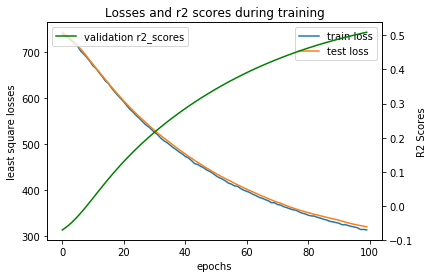

In [2]:
model = Model(n_features, layer_sizes=[])
model.train(X, Y, sold, epochs=100)
model.visualize('linear_regression')

epoch: 0 train loss:  689.9313 val loss:  630.0008 r2_score: 0.04803066649445542
epoch: 10 train loss:  209.15294 val loss:  215.0515 r2_score: 0.6352679239475545
epoch: 20 train loss:  185.89114 val loss:  193.44214 r2_score: 0.6627443886777481
epoch: 30 train loss:  176.11447 val loss:  184.87082 r2_score: 0.6744012049265327
epoch: 40 train loss:  172.80984 val loss:  180.92104 r2_score: 0.6791372709043046
epoch: 50 train loss:  170.78627 val loss:  177.73877 r2_score: 0.6829844569976983
epoch: 60 train loss:  169.82655 val loss:  177.90044 r2_score: 0.6838527922459697
epoch: 70 train loss:  168.46028 val loss:  175.68195 r2_score: 0.6860600741068887
epoch: 80 train loss:  168.76463 val loss:  174.78992 r2_score: 0.687502330973101
epoch: 90 train loss:  168.13344 val loss:  173.97575 r2_score: 0.688848211537685


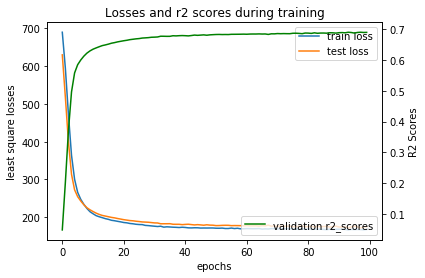

In [3]:
model = Model(n_features, layer_sizes=[64])
model.train(X, Y, sold, epochs=100)
model.visualize('one_hidden_layer')

epoch: 0 train loss:  614.5243 val loss:  444.87326 r2_score: 0.3077211183615254
epoch: 10 train loss:  175.66595 val loss:  176.8912 r2_score: 0.6906767366620392
epoch: 20 train loss:  169.13005 val loss:  173.58383 r2_score: 0.6965809395227867
epoch: 30 train loss:  166.18488 val loss:  174.99335 r2_score: 0.6983837309573537
epoch: 40 train loss:  165.35892 val loss:  171.62273 r2_score: 0.7026864586451975
epoch: 50 train loss:  163.72243 val loss:  168.6135 r2_score: 0.7048352028541753
epoch: 60 train loss:  163.20418 val loss:  169.16408 r2_score: 0.7046348162067407
epoch: 70 train loss:  160.28067 val loss:  169.72609 r2_score: 0.7063589200864321
epoch: 80 train loss:  160.43257 val loss:  167.2694 r2_score: 0.7080839072231871
epoch: 90 train loss:  159.03116 val loss:  164.05954 r2_score: 0.710055595013489


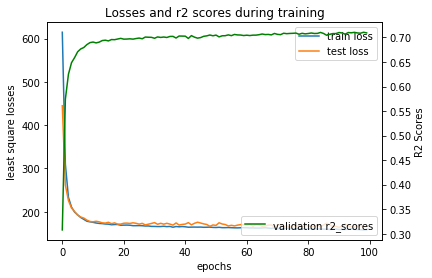

In [4]:
model = Model(n_features, layer_sizes=[64, 64])
model.train(X, Y, sold, epochs=100)
model.visualize('two_hidden_layers')